In [2]:
import requests
import zipfile
import io
import os

# URL for the dataset
url = "https://ti.arc.nasa.gov/c/6/"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    try:
        # Check if the content is likely a zip file by looking at the content type header
        content_type = response.headers.get('content-type')
        if content_type and 'zip' in content_type:
            # Create a ZipFile object from the content
            zip_file = zipfile.ZipFile(io.BytesIO(response.content))
            # Extract all the files into the current directory
            zip_file.extractall()
            print("Dataset downloaded and extracted successfully!")
            # List the extracted files
            print("\nExtracted files:")
            for name in zip_file.namelist():
                print(name)
        else:
            print("The downloaded content is not a zip file.")
            # Optionally, save the downloaded content to inspect it
            with open("downloaded_content", "wb") as f:
                f.write(response.content)
            print("Downloaded content saved as 'downloaded_content'.")

    except zipfile.BadZipFile:
        print("Error: The downloaded content is not a valid zip file.")

else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")

The downloaded content is not a zip file.
Downloaded content saved as 'downloaded_content'.


In [4]:
!pip install kaggle

In [5]:
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

# Move the file to the correct directory
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [8]:
# Download the dataset from Kaggle
!kaggle datasets download -d behrad3d/nasa-cmaps --unzip

print("\nDataset downloaded and unzipped successfully from Kaggle!")

Dataset URL: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps
License(s): CC0-1.0
  0% 0.00/12.3M [00:00<?, ?B/s]
100% 12.3M/12.3M [00:00<00:00, 1.67GB/s]

Dataset downloaded and unzipped successfully from Kaggle!


--- Checking for data file ---
Success! Found 'CMaps/train_FD001.txt'. Proceeding to load data.

--- First 5 rows of the dataset ---
     engine_id  time_in_cycles  setting_1  setting_2  setting_3  sensor_1  \
1 1    -0.0007         -0.0004      100.0     518.67     641.82   1589.70   
  2     0.0019         -0.0003      100.0     518.67     642.15   1591.82   
  3    -0.0043          0.0003      100.0     518.67     642.35   1587.99   
  4     0.0007          0.0000      100.0     518.67     642.35   1582.79   
  5    -0.0019         -0.0002      100.0     518.67     642.37   1582.85   

     sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_10  sensor_11  \
1 1   1400.60     14.62     21.61    554.36  ...     521.66    2388.02   
  2   1403.14     14.62     21.61    553.75  ...     522.28    2388.07   
  3   1404.20     14.62     21.61    554.26  ...     522.42    2388.03   
  4   1401.87     14.62     21.61    554.45  ...     522.86    2388.08   
  5   1406.22     14.62     21.61 

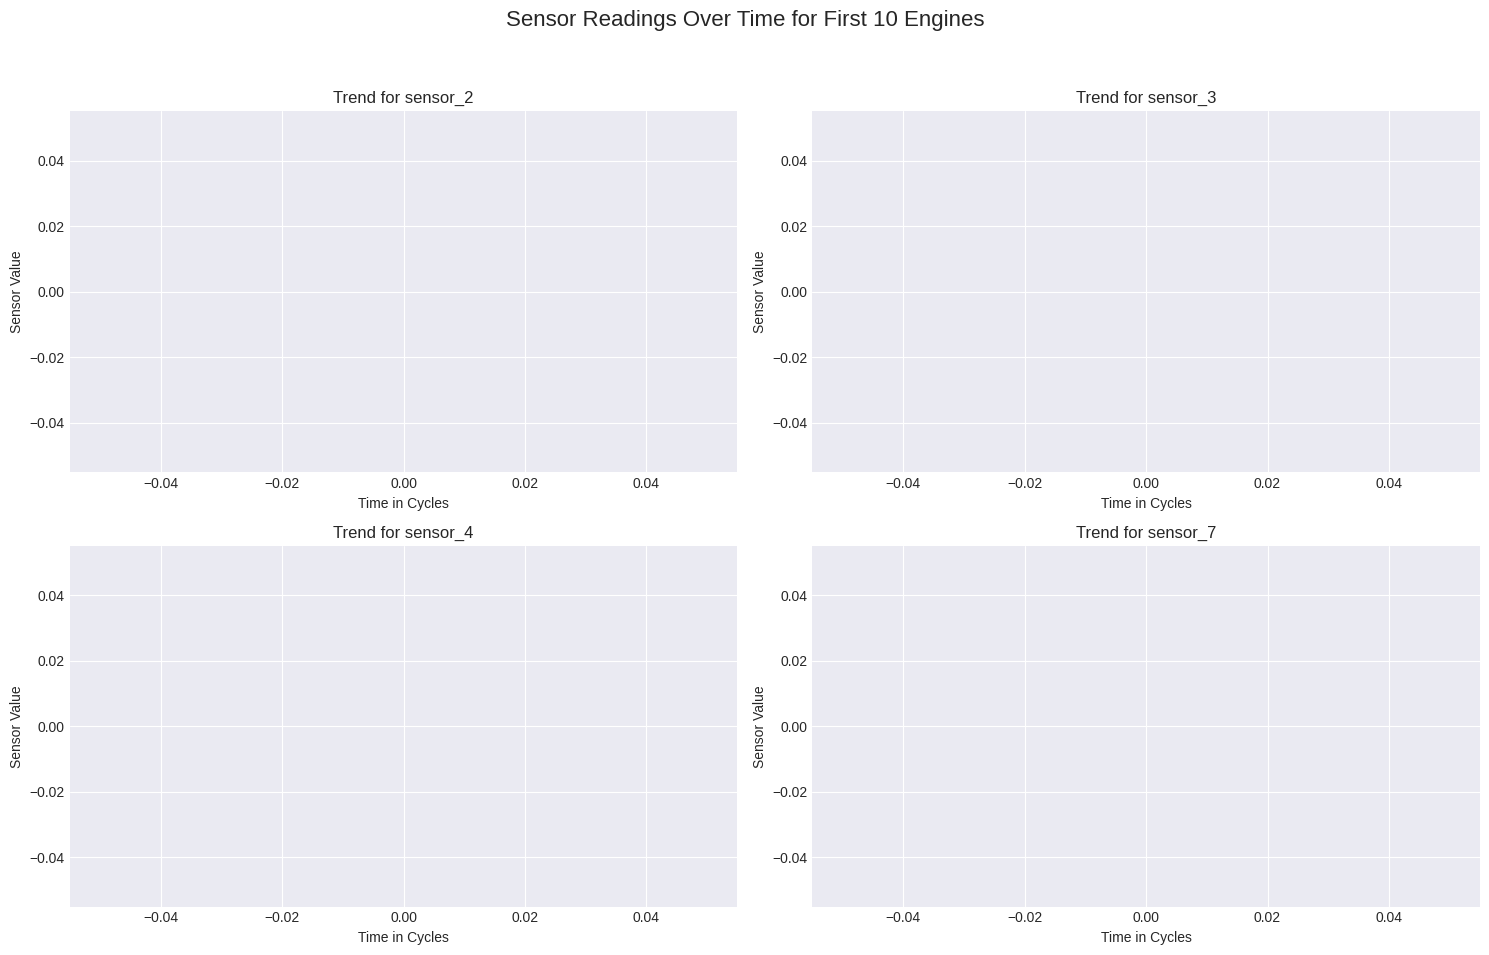

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 0. Verify File Existence ---
# This step helps debug FileNotFoundError by checking if the data file is in the right place.
# The Kaggle command unzipped the files into a 'CMaps' directory.
file_path = 'CMaps/train_FD001.txt'
print("--- Checking for data file ---")

if not os.path.exists(file_path):
    print(f"ERROR: The file '{file_path}' was not found.")
    print("Please make sure you have run the Kaggle API download steps correctly in this notebook session.")
    print("\nFiles currently in your directory are:")
    # List all files in the current directory and subdirectories to help find the correct path
    for root, dirs, files in os.walk('.'):
        for name in files:
            print(os.path.join(root, name))
else:
    print(f"Success! Found '{file_path}'. Proceeding to load data.\n")

    # --- 1. Load the Data ---

    # Define the column names for the dataset
    # Based on the dataset's documentation
    column_names = ['engine_id', 'time_in_cycles', 'setting_1', 'setting_2', 'setting_3']
    column_names += [f'sensor_{i}' for i in range(1, 22)]

    # Load the training data from the text file
    train_df = pd.read_csv(file_path, sep=' ', header=None, names=column_names)

    # The file has extra empty columns at the end, let's drop them
    train_df.dropna(axis=1, how='all', inplace=True)

    # Display the first 5 rows of the dataframe
    print("--- First 5 rows of the dataset ---")
    print(train_df.head())

    # Display basic information about the dataset
    print("\n--- Dataset Info ---")
    train_df.info()


    # --- 2. Visualize Sensor Data ---

    # Let's visualize the trend of a few sensors for the first 10 engines
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Sensor Readings Over Time for First 10 Engines', fontsize=16)

    # Sensors to plot
    sensors_to_plot = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7']

    for i, sensor in enumerate(sensors_to_plot):
        ax = axes[i//2, i%2]
        # Plot data for the first 10 engines
        for engine in range(1, 11):
            engine_data = train_df[train_df['engine_id'] == engine]
            ax.plot(engine_data['time_in_cycles'], engine_data[sensor], label=f'Engine {engine}' if engine==1 else None)
        ax.set_title(f'Trend for {sensor}')
        ax.set_xlabel('Time in Cycles')
        ax.set_ylabel('Sensor Value')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 1. Reload the Data (to make this cell self-contained) ---
file_path = 'CMaps/train_FD001.txt'
column_names = ['engine_id', 'time_in_cycles', 'setting_1', 'setting_2', 'setting_3']
column_names += [f'sensor_{i}' for i in range(1, 22)]
train_df = pd.read_csv(file_path, sep=' ', header=None, names=column_names)
train_df.dropna(axis=1, how='all', inplace=True)


# --- 2. Calculate Remaining Useful Life (RUL) ---
# The RUL is the number of cycles an engine has left before it fails.
# First, we find the maximum (final) cycle for each engine.
max_cycles = train_df.groupby('engine_id')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['engine_id', 'max_cycles']

# Merge this back into the original dataframe
train_df = pd.merge(train_df, max_cycles, on='engine_id', how='left')

# Calculate RUL by subtracting the current cycle from the max cycle
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']

# Drop the 'max_cycles' column as we no longer need it
train_df.drop('max_cycles', axis=1, inplace=True)

print("--- Dataframe with RUL calculated ---")
print(train_df[['engine_id', 'time_in_cycles', 'RUL']].head())


# --- 3. Feature Selection and Scaling ---

# We will use the sensor readings and operational settings as our features.
# Let's define the columns we will use. Some sensors have no variance and are useless.
# Let's find columns that have a standard deviation of 0
constant_cols = [col for col in train_df.columns if train_df[col].std() == 0]
print(f"\nDropping constant columns: {constant_cols}")

# The target variable is 'RUL'
target = 'RUL'

# The features are all columns except IDs, the target, and constant columns
features = [col for col in train_df.columns if col not in ['engine_id', 'time_in_cycles', target] + constant_cols]

print(f"\nSelected features for the model: {features}")

# Initialize the MinMax Scaler
# This scales all features to be between 0 and 1. It's crucial for neural networks.
scaler = MinMaxScaler()

# Fit and transform the features
train_df[features] = scaler.fit_transform(train_df[features])

print("\n--- First 5 rows after scaling features ---")
print(train_df.head())


--- Dataframe with RUL calculated ---
   engine_id  time_in_cycles     RUL
0    -0.0007         -0.0004  0.0010
1     0.0019         -0.0003  0.0009
2    -0.0043          0.0003  0.0002
3     0.0007          0.0000  0.0005
4    -0.0019         -0.0002  0.0007

Dropping constant columns: ['setting_1', 'sensor_16', 'sensor_17']

Selected features for the model: ['setting_2', 'setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_18', 'sensor_19']

--- First 5 rows after scaling features ---
   engine_id  time_in_cycles  setting_1  setting_2  setting_3  sensor_1  \
0    -0.0007         -0.0004      100.0        0.0   0.183735  0.406802   
1     0.0019         -0.0003      100.0        0.0   0.283133  0.453019   
2    -0.0043          0.0003      100.0        0.0   0.343373  0.369523   
3     0.0007          0.0000      100.0        0.0   0

--- Training XGBoost Model ---

XGBoost Model RMSE: 0.00

--- LSTM Data Shapes ---
X_train_lstm shape: (12340, 50, 19)
y_train_lstm shape: (12340,)

--- Building and Training LSTM Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        14,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,251 (133.79 KB)

 Trainable params: 34,251 (133.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0013 - val_loss: 4.4982e-06
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 8.6141e-05 - val_loss: 1.7707e-06
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 4.1802e-05 - val_loss: 1.7359e-06
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 2.5585e-05 - val_loss: 5.6945e-07
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 1.8033e-05 - val_loss: 4.7207e-07
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 1.3956e-05 - val_loss: 4.2412e-07
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 1.0737e-05 - val_loss: 4.7844e-07
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 8.4724e-06 - val_loss: 3.0035e-07
Epoch 9/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 6.5816e-06 - val_loss: 2.3499e-07
Epoch 10/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 5.6869e-06 - val_loss: 3.0275e-07
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

LSTM Mo

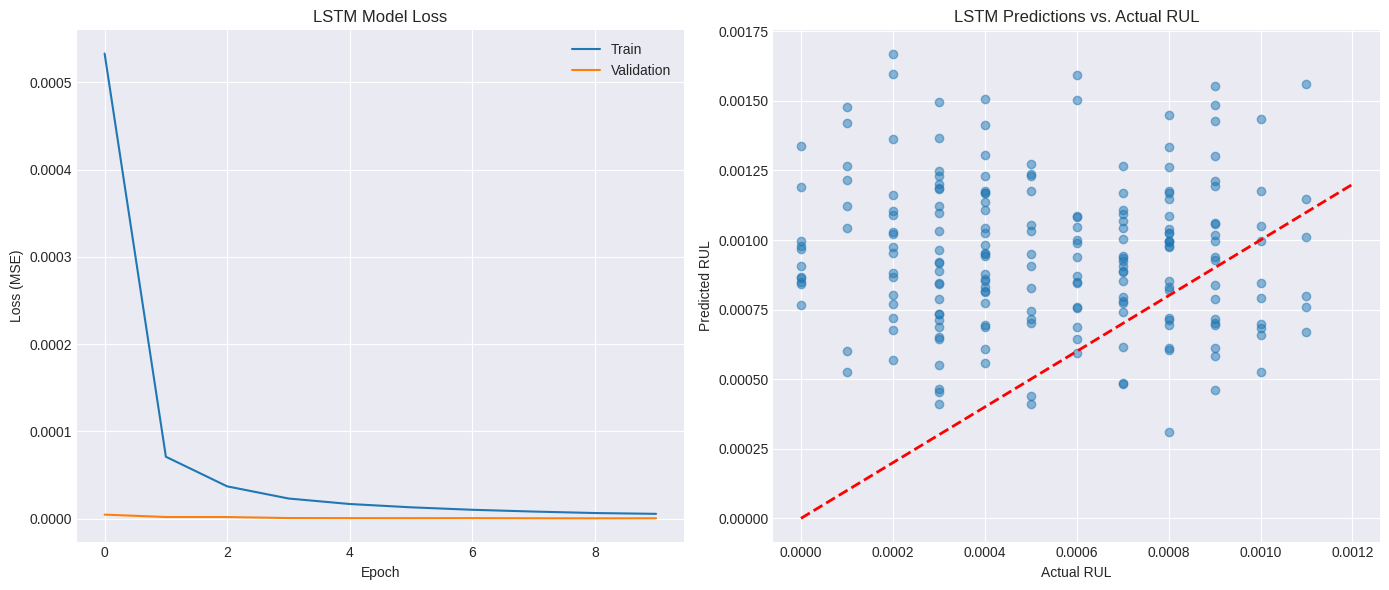

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# --- 1. Reload and Preprocess Data (to make this cell self-contained) ---
file_path = 'CMaps/train_FD001.txt'
column_names = ['engine_id', 'time_in_cycles', 'setting_1', 'setting_2', 'setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
train_df = pd.read_csv(file_path, sep=' ', header=None, names=column_names)
train_df.dropna(axis=1, how='all', inplace=True)

max_cycles = train_df.groupby('engine_id')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['engine_id', 'max_cycles']
train_df = pd.merge(train_df, max_cycles, on='engine_id', how='left')
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']
train_df.drop('max_cycles', axis=1, inplace=True)

constant_cols = [col for col in train_df.columns if train_df[col].std() == 0]
train_df.drop(columns=constant_cols, inplace=True)

target = 'RUL'
features = [col for col in train_df.columns if col not in ['engine_id', 'time_in_cycles', target]]

scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])

# --- 2. Train and Evaluate XGBoost Model (Baseline) ---
print("--- Training XGBoost Model ---")
X = train_df[features]
y = train_df[target]

# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_reg.fit(X_train, y_train)

# Make predictions and evaluate
preds_xgb = xgb_reg.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds_xgb))
print(f"\nXGBoost Model RMSE: {rmse_xgb:.2f}\n")


# --- 3. Prepare Data for LSTM Model ---
# LSTM expects data in a 3D format: [samples, time_steps, features]
# We will create sequences of data. For example, use the last 50 cycles to predict the RUL.
sequence_length = 50

def create_sequences(df, seq_length, features, target):
    X_seq, y_seq = [], []
    for engine_id, group in df.groupby('engine_id'):
        engine_features = group[features].values
        engine_target = group[target].values
        for i in range(len(group) - seq_length + 1):
            X_seq.append(engine_features[i:i+seq_length])
            y_seq.append(engine_target[i+seq_length-1])
    return np.array(X_seq), np.array(y_seq)

X_lstm, y_lstm = create_sequences(train_df, sequence_length, features, target)

# Split LSTM data for training and validation
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

print(f"--- LSTM Data Shapes ---")
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")


# --- 4. Build, Train, and Evaluate LSTM Model ---
print("\n--- Building and Training LSTM Model ---")
n_features = X_train_lstm.shape[2]

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, n_features)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()

# Train the model
# Using a smaller number of epochs for a quick run. Increase for better performance.
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_val_lstm, y_val_lstm), verbose=1)

# Make predictions and evaluate
preds_lstm = model_lstm.predict(X_val_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_val_lstm, preds_lstm))
print(f"\nLSTM Model RMSE: {rmse_lstm:.2f}")


# --- 5. Visualize Results ---
plt.figure(figsize=(14, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot predictions vs actual values for a sample
plt.subplot(1, 2, 2)
plt.scatter(y_val_lstm[:200], preds_lstm[:200], alpha=0.5)
plt.plot([y_val_lstm.min(), y_val_lstm.max()], [y_val_lstm.min(), y_val_lstm.max()], 'r--', lw=2)
plt.title('LSTM Predictions vs. Actual RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.tight_layout()
plt.show()

